Group: 31  
Members: Linus Kleine Kruthaup, Isabel Grauwelman, Mara Rehmer  
Week 3

In [8]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# 1 Data set

## Loading the data

In [9]:
# We separate test and train data and already randomly take out 1000 test and 100000 train samples
# we set 'as_supervised = True' so that the labels are included in the dataset
ds_test, ds_train = tfds.load('genomics_ood', as_supervised= True, shuffle_files = True, split=['test[:1000]', 'train[:100000]'])

## One-hot-encoding

In [10]:
# Since the genomic sequences come as string-tensors, we use the given onehotify function.
# It converts the genomic sequences consisting of combination of 'A','G','C' and 'T' to a tensor that
# contains the one-hot-encoded sequence
def onehotify(tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot


## Input pipeline

In [11]:
# Now we use the onehotify() function for the genomic sequence input and the tf.one_hot() function for the targets/labels.
# We do that to the test and the train dataset respectively.
# To improve runtime, we include batch(128) and prefetch(5).
# batch(128) groups multiple datapoints together.
# prefetch(2) allows later elements to be prepared while the current element is being processed.
test_dataset = ds_test.map(lambda input, target: (onehotify(input), tf.one_hot(target, 10))).batch(128).prefetch(2)
train_dataset = ds_train.map(lambda input, target: (onehotify(input), tf.one_hot(target, 10))).batch(128).prefetch(2)

# 2 Model

In [12]:
# We will implement a simple fully connected feed forward neural network with the following layers:
#
# Hidden layer 1: 256 units. With sigmoid activation function.
# Hidden layer 2: 256 units. With sigmoid activation function.
# Output: 10 units. With softmax activation function.

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

# 3 Training

In [13]:
# Train the model
# defining the training step with the loss and optimizer object from the tensorflow classes
def train_step(model, input, target, loss_function, optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

# We test over the complete test data
def test(model, test_dataset, loss_function):
  # Initializing lists for the accuracy and the loss respectively
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_dataset:
    prediction = model(input)
    # we compute the loss
    sample_test_loss = loss_function(target, prediction)
    # and the accuracy
    sample_test_accuracy = np.argmax(target, axis = 1) == np.argmax(prediction, axis = 1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    # We append the sample test loss to our loss list
    test_loss_aggregator.append(sample_test_loss.numpy())
    # We append the mean sample test accuracy to our accuracy list
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)
  # We return the mean test loss and the mean test accuracy
  return test_loss, test_accuracy


In [14]:
# We use the clear_session() to avoid clutter from old models and layers
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initializing the model:
model = Model()
# Initializing the loss with categorical cross entropy
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initializing the optimizer with SGD
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initializing lists for later visualization
train_losses = []
test_losses = []
test_accuracies = []

# testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# checking how the model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for the defines 10 epochs
for epoch in range(num_epochs):
  print('Epoch: ___' + str(epoch))

  train_dataset = train_dataset.shuffle(buffer_size = 128)
  test_dataset = test_dataset.shuffle(buffer_size = 128)
   
  # We compute the running average 
  running_average = 0
  for (input,target) in train_dataset:
      train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
      running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
  train_losses.append(running_average)

  # testing
  test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)


Epoch: ___0
Epoch: ___1
Epoch: ___2
Epoch: ___3
Epoch: ___4
Epoch: ___5
Epoch: ___6
Epoch: ___7
Epoch: ___8
Epoch: ___9


# Visualization

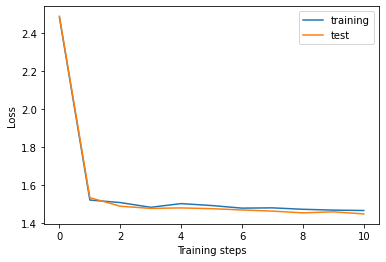

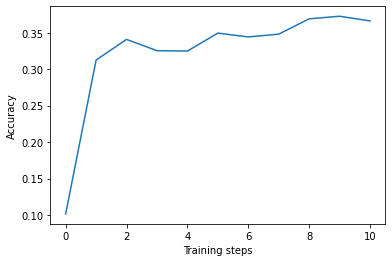

In [15]:
# We visualize accuracy and loss for training and test data
# One plot is for training and test loss, one is for training and test accuracy.

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

# Saving

In [16]:
# saving the model

model.save_weights('genomics_ood_mlp.h5')